# This Notebook describes how a traditional wave buoy record Wave Parameters (Significant Wave Height, dominant Period, and integrated parameters in general)
### Use CDIP Buoy data
##### g.marechal (Brest 2023)

In [1]:
# Import Library
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import detrend, welch


import xarray as xr

from SwellPractical_fct import *

In [2]:
g = 9.81 #Gravitational acceleration

### Define the paths to the data and open them with xarray

In [3]:
Buoy_id = '029'
path_buoy_mvt = ('http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/%sp1_xy.nc?xyzStartTime,xyzSampleRate,xyzFilterDelay,xyzZDisplacement[0:1:60208296],xyzXDisplacement[0:1:60208296],xyzYDisplacement[0:1:60208296]'%Buoy_id)
path_buoy_param = ('http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/%sp1_rt.nc?waveTime[0:1:26125],waveHs[0:1:26125],waveDp[0:1:26125],waveTp[0:1:26125],waveFrequency[0:1:63],waveEnergyDensity[0:1:26125][0:1:63],waveA1Value[0:1:26125][0:1:63],waveB1Value[0:1:26125][0:1:63],waveA2Value[0:1:26125][0:1:63],waveB2Value[0:1:26125][0:1:63]'%Buoy_id)

ds_xyz_buoy = xr.open_dataset(path_buoy_mvt)
ds_wave_param = xr.open_dataset(path_buoy_param)

sub_ds_wave_param = ds_wave_param.sel(waveTime = '2021-01-26T21:00', method = 'nearest')
# If Offline download the data here:
#'http://thredds.cdip.ucsd.edu/thredds/catalog/cdip/archive/029p1/catalog.html?dataset=CDIP_Archive/029p1/029p1_historic.nc'

### Define the time axis

In [4]:
arrayIndex = np.arange(300, 2_100, 1)
sub_ds_xyz_buoy = ds_xyz_buoy.sel(xyzCount = slice(np.amin(arrayIndex), np.amax(arrayIndex)))  # Load the first 1 000 data

### Create the UTC time axis

In [5]:
time_array = create_UTC_axis(sub_ds_xyz_buoy, arrayIndex)

##### Even if the buoy is anchored, it has a three-dimensional motion (East-West, North-South, Up-Down). These motions provide a directional description of the wave field as well as its amplitude

Text(0.5, 0, 'Time UTC')

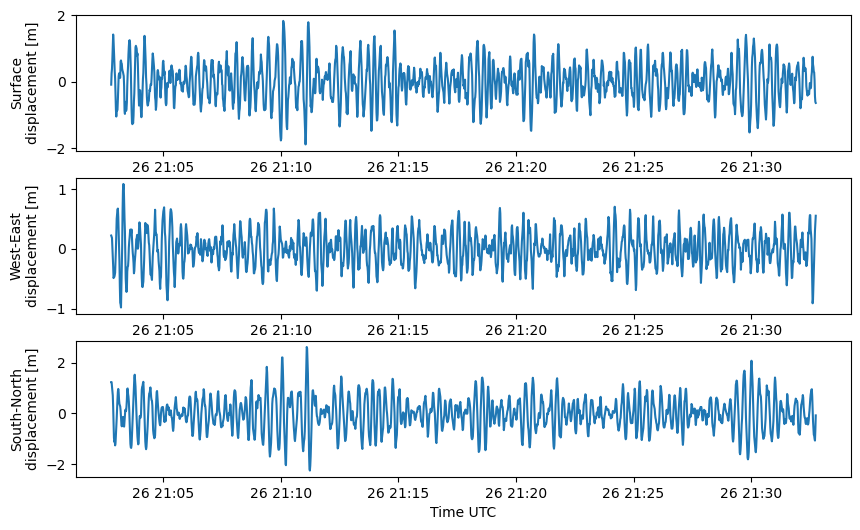

In [6]:
plt.figure(figsize = (10, 6))
plt.subplot(311)
plt.plot(time_array[:-1], sub_ds_xyz_buoy.xyzZDisplacement.values)
plt.ylabel('Surface\ndisplacement [m]')
plt.subplot(312)
plt.plot(time_array[:-1], sub_ds_xyz_buoy.xyzXDisplacement.values)
plt.ylabel('West-East\ndisplacement [m]')

plt.subplot(313)
plt.plot(time_array[:-1], sub_ds_xyz_buoy.xyzYDisplacement.values)
plt.ylabel('South-North\ndisplacement [m]')
plt.xlabel('Time UTC')


### One can see the Surface displacement (the first panel) is not strictly sinusoidal. How can we describe the statistics of the wave signal (period and amplitude) over these 30 minutes record? $\rightarrow$ this is the aim of this practical

##### TODO_1: Estimate the dominant wave period from the first panel. How many crest for a given time interval?

In [7]:
# TODO1:

### Spectral analysis

The spectral resolution is 0.0006670372429127293 Hz




Text(0, 0.5, 'Wave Energy Density [$m^{2}/Hz$]')

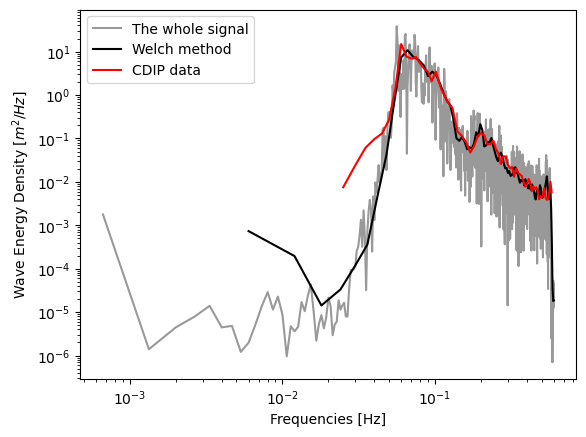

In [13]:
freq, spec_corr= wave_frequency_spectrum(sub_ds_xyz_buoy.xyzZDisplacement.values, Fs = 1.2)
freq_ov, spec_corr_ov = wave_frequency_spectrum_overlap(sub_ds_xyz_buoy.xyzZDisplacement.values, 50, 200,  Fs = 1.2)
dfreq = np.gradient(freq_ov)

fig, ax = plt.subplots()
ax.loglog(freq, spec_corr, color = 'k', alpha = .4, label = 'The whole signal')
ax.loglog(freq_ov, spec_corr_ov, color = 'k', label = 'Welch method')
ax.loglog(sub_ds_wave_param.waveFrequency, sub_ds_wave_param.waveEnergyDensity, color = 'r', label = 'CDIP data')
ax.legend()
ax.set_xlabel('Frequencies [Hz]')
ax.set_ylabel('Wave Energy Density [$m^{2}/Hz$]')

### The plot above is the frequency spectrum. It shows how the variance of the wave field is distributed along the frequencies. The short waves stand on the high frequencies and vice versa.

##### TODO_2: Estimate the dominant period from the spectrum and compare it with your first guess? You can verify it with the period provided by the CDIP file_param

In [9]:
###TODO2:

### Uncertainty?

In [10]:
### Bia: Do you want them to compute the uncertainty? Or should I provide this section?

### The Significant Wave Height ($H_s$) describe how big are the waves in your wave field. This values is based on the statistics of the wave field. For one spectrum, or for a ... minutes record, there is ONE value of the significant wave height. According to the Parseval theorem, the $H_s$ are identical if you compute them from the spectrum or the variance of the sea elevation record. 

##### TODO_3: Do you think that computing the significant wave height over a shorter time window is relevant? (Like over one or two dominant period)

In [ ]:
###TODO3:

In [16]:
print(f'The significant wave height from the CDIP program is equal to {sub_ds_wave_param.waveHs.values} m')
print('\n')
print(f'The significant wave height from the variance of the elevation is equal to {4*np.sqrt(np.var(sub_ds_xyz_buoy.xyzZDisplacement.values))} m')
print('\n')
print(f'The significant wave height from my spectrum is equal {4*np.sqrt(np.sum(spec_corr_ov * dfreq))} m')

The significant wave height from the CDIP program is equal to 2.2899999618530273 m


The significant wave height from the variance of the elevation is equal to 2.3421339988708496 m


The significant wave height from my spectrum is equal 2.270807015712669 m


##### One can see that the two files return the same $H_{s}$, but saving all the displacements of the buoy is costly in memory. This is the main motivation why only the statistics of the wave field are provided for operational applications (wave forecast)

======================================================================================================================================================

# What is the wave direction?

### Now we know at what period (frequency) the energy is, what about the directional properties of the wave field?

##### One can see that there are $a1$, $a2$, $b1$, $b2$ parameters in the wave parama file. They are called the Fourier parameters. They are based on both the vertical and the horizontal motions of the buoy (horizontals motions are plot at the very top of the notebook). From these parameters and the elevation frequency spectrum, one can estimate the directional properties of the wave record.

##### $a1(f)$ = $\int_{0}^{2\pi} E(f) cos \theta d\theta$
##### $a2(f)$ = $\int_{0}^{2\pi} E(f) cos 2\theta d\theta$
##### $b1(f)$ = $\int_{0}^{2\pi} E(f) cos \theta d\theta$
##### $b2(f)$ = $\int_{0}^{2\pi} E(f) cos 2\theta d\theta$

In [17]:
sf = sub_ds_wave_param.waveEnergyDensity.values
a1 = sub_ds_wave_param.waveA1Value
a2 = sub_ds_wave_param.waveA2Value
b1 = sub_ds_wave_param.waveB1Value
b2 = sub_ds_wave_param.waveB2Value

### Combining the wave energy spectrum with the directional moments, one can describe both in direction and frequencies/wavelength the wave field

/Users/gwen29360/Desktop/POSTDOC/Mines/S_MODE/python/WAVES/BUOY/SwellPractical_fct.py:261: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


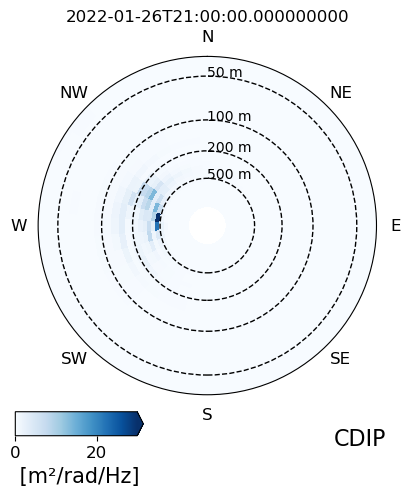

In [18]:
dir_vec = np.arange(0,360,10)*np.pi/180
FREQS, DIRS = np.meshgrid(sub_ds_wave_param.waveFrequency, dir_vec)

sp2d, D = buoy_spectrum2d(sf, a1, a2, b1, b2, dirs = dir_vec*180/np.pi)


time_spec = sub_ds_wave_param.waveTime.values
plot_polar_spectrum(sp2d, DIRS, FREQS, time_spec, vmin0 = 0, vmax0 = 30, cbar = 1, date_on = 1)

##### TODO_4: what is the dominant wave direction for this directional spectrum? You can compare your result with the value given in the param_file. One can see that the polar plot provides wavelength in stead of frequency. What is the name of the relation that relate frequencies to wavelengths? Confirm the position of the energy on the polar plot with the dominant frequency spotted before

In [19]:
#TODO_4:

dominant_period = 0.00001 # Dominant period computed in TODO_2
dominant_freq = 1/dominant_period
wavenumber = (2*np.pi*dominant_freq)**2/g # The name of this relation is:
wavelength = 2*np.pi/wavenumber
print(f'The dominant wavelength is {wavelength} m')


The dominant wavelength is 1.5613099917314935e-10 m


##### TODO_5: According to the position of the Buoy, what is the convention of the wave direction? i.e. waves are going toward ... or are coming from ... Why?

In [20]:
print(f'The wave buoy is anchored at {ds_wave_param.geospatial_lon_min} degree East {ds_wave_param.geospatial_lat_min} degree North')
#TODO_5:

The wave buoy is anchored at -123.47545623779297 degree East 37.93207550048828 degree North


### The previous case is for a very idealized swell case. In nature we can have a multiple seas (swell, or local wind-induced waves)

### A more complexe wave system

In [21]:
sub_ds_wave_param_new = ds_wave_param.sel(waveTime = '2023-07-25T00:00', method = 'nearest')


sf = sub_ds_wave_param_new.waveEnergyDensity.values
a1 = sub_ds_wave_param_new.waveA1Value
a2 = sub_ds_wave_param_new.waveA2Value
b1 = sub_ds_wave_param_new.waveB1Value
b2 = sub_ds_wave_param_new.waveB2Value

dir_vec = np.arange(0,360,10)*np.pi/180
FREQS, DIRS = np.meshgrid(sub_ds_wave_param_new.waveFrequency, dir_vec)

sp2d, D = buoy_spectrum2d(sf, a1, a2, b1, b2, dirs = dir_vec*180/np.pi)

In [22]:
########
# ---  Wind data from the closest wind buoy
########
wind_dir = 312
wind_vel = 7.1

/Users/gwen29360/Desktop/POSTDOC/Mines/S_MODE/python/WAVES/BUOY/SwellPractical_fct.py:261: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


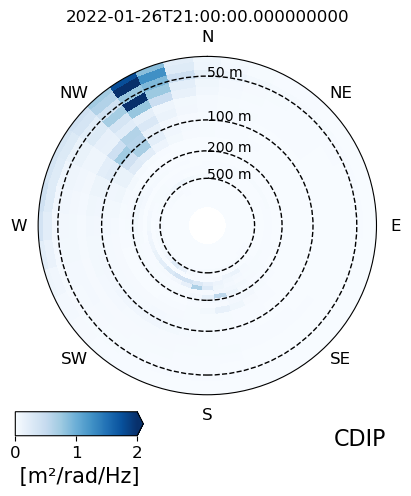

In [23]:
plot_polar_spectrum(sp2d, DIRS, FREQS, time_spec, vmin0 = 0, vmax0 = 2, cbar = 1, date_on = 1)

##### TODO_6: Do you think waves and wind are always aligned? What are the properties of the two wave systems (dominant direction and frequencies)?

In [24]:
### TODO_6:

##### TODO_7: Choose a random (or not) date in 2022 and describe the wave system (Significant wave height, dominant wave period, and dominant wave direction)

/Users/gwen29360/Desktop/POSTDOC/Mines/S_MODE/python/WAVES/BUOY/SwellPractical_fct.py:261: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


The significant wave heigth is 0
The dominant wave period is 0
The dominant wave direction is 0


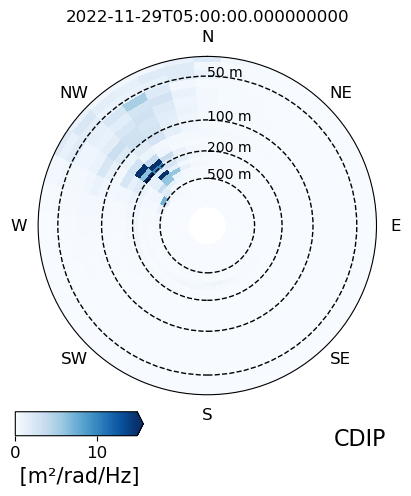

In [37]:
date_spectrum = np.datetime64('2022-11-29T05:00')  # Edit the date here (stay in 2022)
sub_ds_wave_param_my_date = ds_wave_param.sel(waveTime = date_spectrum, method = 'nearest')

time_spec = sub_ds_wave_param_my_date.waveTime.values

sf = sub_ds_wave_param_my_date.waveEnergyDensity.values
a1 = sub_ds_wave_param_my_date.waveA1Value
a2 = sub_ds_wave_param_my_date.waveA2Value
b1 = sub_ds_wave_param_my_date.waveB1Value
b2 = sub_ds_wave_param_my_date.waveB2Value

dir_vec = np.arange(0,360,10)*np.pi/180
FREQS, DIRS = np.meshgrid(sub_ds_wave_param_my_date.waveFrequency, dir_vec)

sp2d, D = buoy_spectrum2d(sf, a1, a2, b1, b2, dirs = dir_vec*180/np.pi)

plot_polar_spectrum(sp2d, DIRS, FREQS, time_spec, vmin0 = 0, vmax0 = 15, cbar = 1, date_on = 1) # edit the vmin/vmax in order to not have saturation
print(f'The significant wave heigth is {0}') # the significant wave height
print(f'The dominant wave period is {0}') # the dominant wave period
print(f'The dominant wave direction is {0}') # the dominant wave direction